# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW1')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PyTorch

This code block imports torch and torchvision which provide the libraries for use down below. PyTorch provides many utilities such as standard datasets, for this exercise we will use MNIST. Please see the torchvision documentation for how to instantiate the training and testing data split.

In [ ]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Download MNIST
# torchvision.datasets.MNIST('.', download=True)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Training the Convolutional Neural Network

In [ ]:
# Create your network here
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1,32,5,padding = 2)
    self.conv2 = nn.Conv2d(32,32,5,padding = 2)
    self.conv3 = nn.Conv2d(32,64,5,padding = 2)

    self.norm1 = nn.BatchNorm2d(32)
    self.norm2 = nn.BatchNorm2d(32)
    self.norm3 = nn.BatchNorm2d(64)
    self.norm4 = nn.BatchNorm1d(64)

    # self.softmax = nn.Softmax(dim = 0)

    self.relu = nn.ReLU()

    self.pool = nn.AvgPool2d(kernel_size = 2,stride = 2,padding = 0)

    self.fc1 = nn.Linear(64*3*3,64)
    self.fc2 = nn.Linear(64,10)
    pass
  

  def forward(self, x):
    x = self.relu(self.norm1(self.conv1(x)))
    x = self.pool(x)
    x = self.relu(self.norm2(self.conv2(x)))
    x = self.pool(x)
    x = self.relu(self.norm3(self.conv3(x)))
    x = self.pool(x)

    x = x.view(-1, self.num_flat_features(x))

    x = self.relu(self.norm4(self.fc1(x)))
    # x = self.softmax(self.fc2(x))
    x = self.fc2(x)

    return x


  def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

In [ ]:
# train_data = torch.utils.data.DataLoader('/content/MNIST/processed/training.pt',batch_size=64, shuffle=True)
# test_data = torch.utils.data.DataLoader('/content/MNIST/processed/test.pt',batch_size=64, shuffle=True)
train_set = torchvision.datasets.MNIST('.', transform = torchvision.transforms.ToTensor(), train=True, download=True)
test_set = torchvision.datasets.MNIST('.', transform = torchvision.transforms.ToTensor(), train=False, download=True)

In [ ]:
batch_size = 1000
train_data = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_data = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

In [ ]:
# Instantiate your network here
def create_network():
  net = CNN()
  criterion_CE = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)

  return net,criterion_CE,optimizer

In [ ]:
def train_network(net,criterion_CE,optimizer):
  net.to(device)

  # Train your network here
  num_epochs = 10
  training_loss = torch.zeros(num_epochs)
  testing_loss = torch.zeros(num_epochs)
  num_correct_pred = torch.zeros(num_epochs)

  for epoch in range(num_epochs):
    print("Epoch %d/%d" % (epoch+1, num_epochs))

    net.train()
    for i,(train_imgs,labels) in enumerate(train_data):
      # Transferring images to GPU
      train_imgs = train_imgs.to(device)
      labels = labels.to(device)

      # Normalize
      train_imgs = (train_imgs * 2) - 1

      pred = net(train_imgs)
      train_loss = criterion_CE(pred,labels)

      # if (i + 1) % 10 == 0:
      #   print("Training loss: ",train_loss)
      # .clone().detach()

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      training_loss[epoch] += train_loss.item()

    net.eval()
    with torch.no_grad():
      for j,(test_imgs,labels) in enumerate(test_data):
        # Transferring images to GPU
        test_imgs = test_imgs.to(device)
        labels = labels.to(device)

        # Normalize
        test_imgs = (test_imgs * 2) - 1

        pred = net(test_imgs)
        test_loss = criterion_CE(pred,labels)
        # if (j + 1) % 10 == 0:
        #   print("Testing loss: ",loss)
        testing_loss[epoch] += test_loss.item()

        # Calculating number of correct predictions
        pred_class = torch.argmax(pred,axis = 1)
        num_correct_pred[epoch] += (pred_class == labels).cpu().sum()

  # Saving model's parameters after training
  torch.save(net.state_dict(),'/content/gdrive/My Drive/Penn/3rd Semester/CIS 680/Assignments/Assignment 1/model_parameters.pth')
        
  # Calculating accuracy
  accuracy = (num_correct_pred * 100) / (batch_size * len(test_data))

  # Dividing by number of batches
  training_loss = training_loss/(i + 1)
  testing_loss = testing_loss/(j + 1)

  # print("\nEpochs: ", torch.arange(num_epochs) + 1)
  # print("Training Loss: ",training_loss)
  # print("Validation Loss: ",test_loss)

  plt.figure(1)
  plt.title("Training Curve")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Average Training Loss per Batch")
  plt.plot(np.arange(10) + 1,training_loss)

  plt.figure(2)
  plt.title("Testing Curve")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Average Testing per Batch")
  plt.plot(np.arange(10) + 1,testing_loss)

  plt.figure(3)
  plt.title("Accuracy Curve")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy on Test Data")
  plt.plot(np.arange(10) + 1,accuracy)

  print("Final Accuracy: ", accuracy[-1])

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Final Accuracy:  tensor(99.1200)


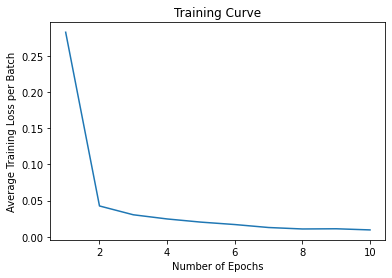

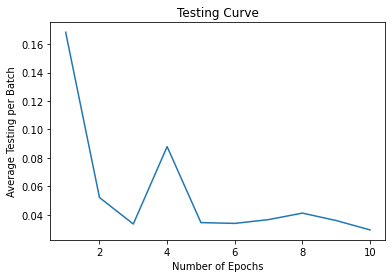

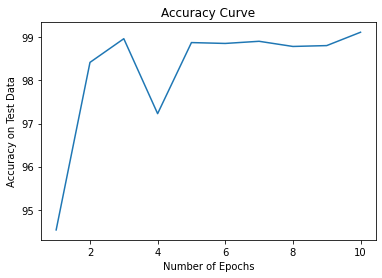

In [ ]:
net,criterion_CE,optimizer = create_network()
train_network(net,criterion_CE,optimizer)

In [ ]:
def get_data(num_images):

  for j,(test_imgs,test_labels) in enumerate(test_data):
    # Transferring images to GPU
    test_imgs = test_imgs.to(device)
    test_labels = test_labels.to(device)

    # Normalize
    test_imgs = (test_imgs * 2) - 1

    break

  images = test_imgs[0:num_images]
  labels = test_labels[0:num_images]

  if torch.numel(labels) == 1:
    labels = labels.view(1)

  # for i in range(num_images):
  #   plt.figure(i)
  #   plt.imshow(images[i].cpu().squeeze())
  #   print(labels[i])


  return images,labels

In [ ]:
# Loading saved model parameters
def load_model():
  model = CNN()
  model.load_state_dict(torch.load('/content/gdrive/My Drive/Penn/3rd Semester/CIS 680/Assignments/Assignment 1/model_parameters.pth'))
  model.eval()
  model.to(device)

  return model

# Creating Adversarial Images

## Creating adversarial images such that the network misclassifies the image as any of the other labels

In [ ]:
def create_adverserial_1(images,labels):

  Softmax = nn.Softmax(dim = 1)
  epsilon = 0.001 
  adversarial_images = torch.zeros_like(images)
  adversarial_labels = torch.zeros_like(labels)

  for i in range(images.shape[0]):
    img = images[i]
    label = labels[i]
    label = label.view(1)

    I = img.clone().unsqueeze(dim = 0)
    I_epsilon = torch.zeros_like(I).to(device)
    confidence = torch.tensor([0])
    prediction = torch.clone(label)
    iter_num = 0   

    while not (prediction != label and confidence > 0.9):
      iter_num += 1
      I_pert = I + I_epsilon
      I_pert = torch.clamp(I_pert,min = -1,max = 1)
      I_pert.requires_grad = True
      # print("I_pert: ",I_pert.requires_grad)

      # Feed I_pert to network and calculate loss and gradient
      pred = model(I_pert)
      loss = criterion_CE(pred,label)

      pred = Softmax(pred)
      confidence,prediction = torch.max(pred,dim = 1)

      loss.backward()
      # print(I_epsilon.grad)
      # print(I_pert.grad)
      gradient = I_pert.grad.data

      gradient = gradient.sign()
      gradient = torch.clamp(gradient,min = 0, max = 1)

      I_epsilon = I_epsilon + (epsilon * gradient)

      pass

    adversarial_images[i] = torch.clone(I_pert)
    adversarial_labels[i] = torch.clone(prediction)

    # print("Number of iterations: ", iter_num)
    # print("Confidence: ",confidence.item()*100)
    # print("Prediction: ",prediction.item())

    plt.figure(2*i + 1)
    plt.title("Original Image")
    plt.imshow(I.cpu().squeeze())
    plt.figure(2*i + 2)
    title = "True label = %i \nPredicted label = %i \n Confidence = %1.4f" %(label,prediction,confidence * 100)
    plt.title(title)
    plt.imshow(I_pert.cpu().detach().squeeze())

    pass


  return adversarial_images,adversarial_labels

In [ ]:
model = load_model()

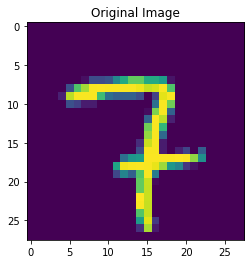

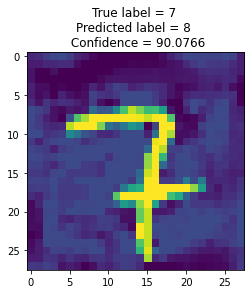

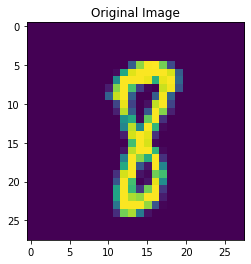

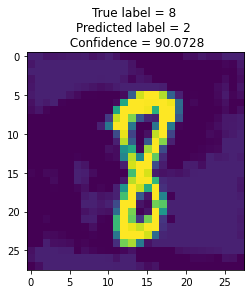

In [ ]:
images,labels = get_data(2)
adversarial_images,adversarial_labels = create_adverserial_1(images,labels)

## Creating adversarial images such that the network misclassifies the image as a chosen target label

In [ ]:
def create_adverserial_2(images,labels):

  Softmax = nn.Softmax(dim = 1)
  epsilon = 0.001 
  adversarial_images = torch.zeros_like(images)
  adversarial_labels = torch.zeros_like(labels)

  for i in range(images.shape[0]):
    img = images[i]
    label = labels[i]
    label = label.view(1)

    I = img.clone().unsqueeze(dim = 0)
    I_epsilon = torch.zeros_like(I).to(device)
    confidence = torch.tensor([0])
    prediction = torch.clone(label)
    iter_num = 0

    # Generating a random target label
    fake_label = torch.randint(low = 0,high = 9,size = (1,)).to(device)
    while fake_label == label:
      fake_label = torch.randint(low = 0,high = 9,size = (1,)).to(device)

    while not (prediction == fake_label and confidence > 0.9):
      iter_num += 1
      I_pert = I + I_epsilon
      I_pert = torch.clamp(I_pert,min = -1,max = 1)
      I_pert.requires_grad = True
      # print("I_pert: ",I_pert.requires_grad)

      # Feed I_pert to network and calculate loss and gradient
      pred = model(I_pert)
      # Negating loss in order to move prediction towards fake_label
      loss = -1 * criterion_CE(pred,fake_label)

      pred = Softmax(pred)
      confidence,prediction = torch.max(pred,dim = 1)

      loss.backward()
      # print(I_epsilon.grad)
      # print(I_pert.grad)
      gradient = I_pert.grad.data

      gradient = gradient.sign()
      gradient = torch.clamp(gradient,min = 0, max = 1)

      I_epsilon = I_epsilon + (epsilon * gradient)

      pass

    adversarial_images[i] = torch.clone(I_pert)
    adversarial_labels[i] = torch.clone(prediction)

    # print("Number of iterations: ", iter_num)
    # print("Confidence: ",confidence.item()*100)
    # print("Prediction: ",prediction.item())

    plt.figure(2*i + 1)
    plt.title("Original Image")
    plt.imshow(I.cpu().squeeze())
    plt.figure(2*i + 2)
    title = "True label = %i \nTarget label = %i \n Predicted label = %i \n Confidence = %1.4f" %(label,fake_label,prediction,confidence * 100)
    plt.title(title)
    plt.imshow(I_pert.cpu().detach().squeeze())

    pass


  return adversarial_images,adversarial_labels

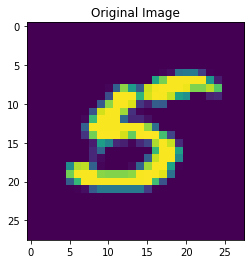

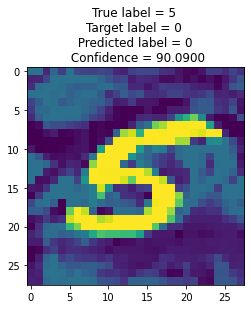

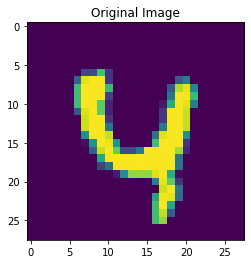

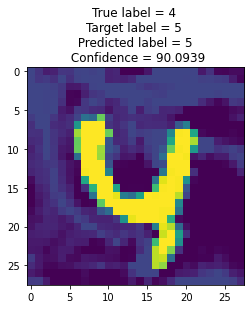

In [ ]:
images,labels = get_data(2)
adversarial_images,adversarial_labels = create_adverserial_2(images,labels)

# Retraining the network
The network is retrained to modify the weights and make it different from the one used to generate the adversarial examples. The adversarial images generated using the old network are passed to the new network to see the effect on the predicted labels.

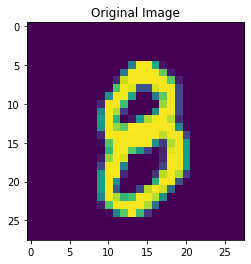

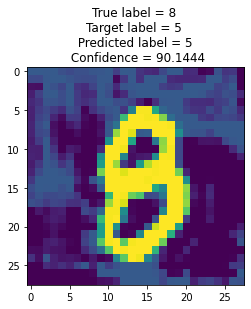

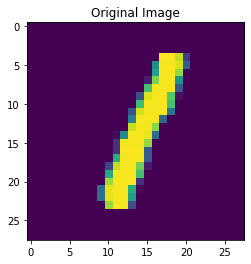

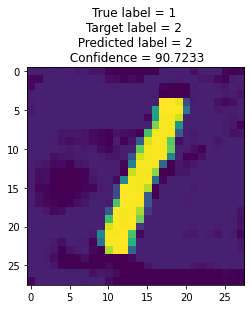

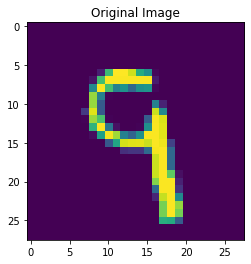

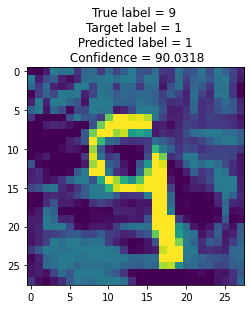

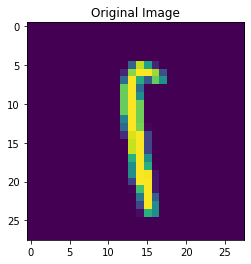

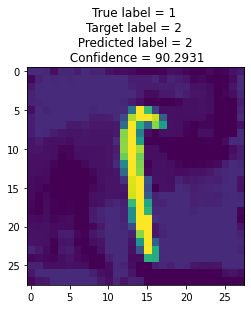

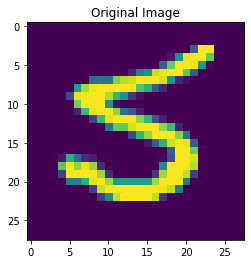

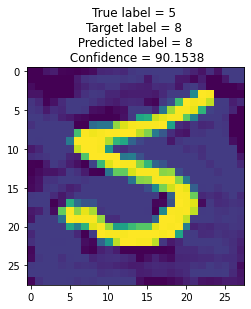

In [ ]:
# Preparing data and generating adversarial images using method 1 and 2
num_images = 10

images,labels = get_data(num_images//2)
adversarial_images = torch.zeros((num_images,images.shape[1],images.shape[2],images.shape[3]))
adversarial_labels = torch.zeros(num_images)
true_labels = torch.zeros(num_images)

adversarial_images[0:num_images//2],adversarial_labels[0:num_images//2] = create_adverserial_1(images,labels)
true_labels[0:num_images//2] = labels

images,labels = get_data(num_images - num_images//2)
adversarial_images[num_images//2:],adversarial_labels[num_images//2:] = create_adverserial_2(images,labels)
true_labels[num_images//2:] = labels

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Final Accuracy:  tensor(99.1100)


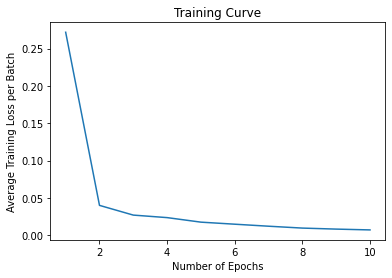

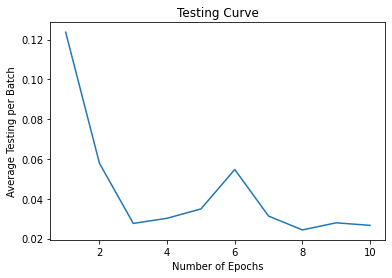

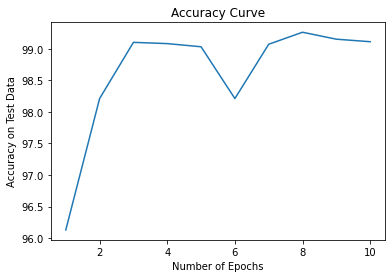

In [ ]:
net,criterion_CE,optimizer = create_network()
train_network(net,criterion_CE,optimizer)
new_model = load_model()

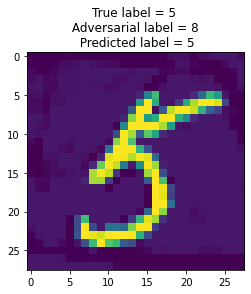

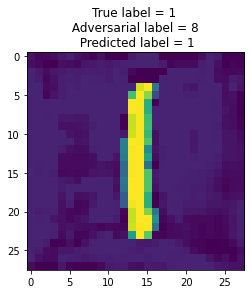

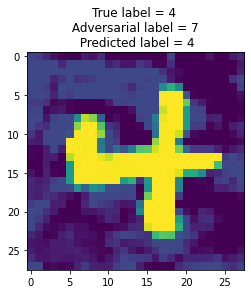

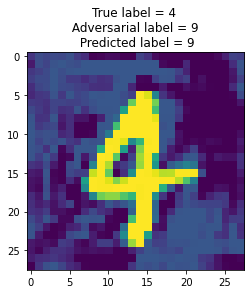

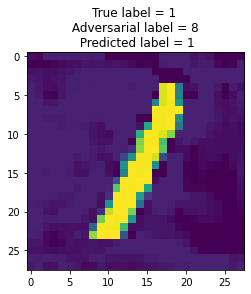

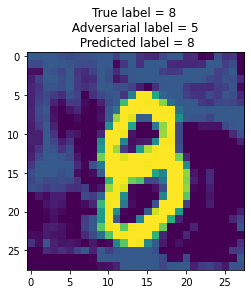

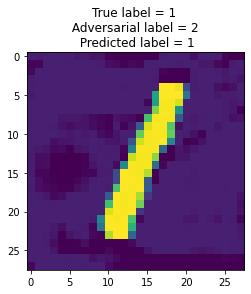

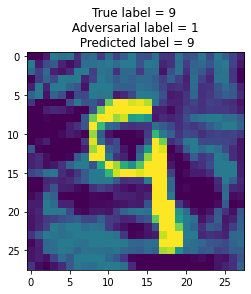

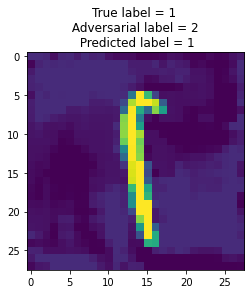

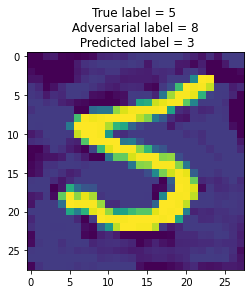

In [ ]:
# Passing adversarial images as input to newly trained network
adversarial_images = adversarial_images.to(device)

pred = new_model(adversarial_images)
prediction = torch.argmax(pred,axis = 1)

for i in range(num_images):
  plt.figure(i)
  title = "True label = %i \n Adversarial label = %i \n Predicted label = %i" %(true_labels[i],adversarial_labels[i],prediction[i])
  plt.title(title)
  plt.imshow(adversarial_images[i].cpu().detach().squeeze())